# Changes from v2: 
- Reverted back to ReLU for the Generator.
- Applied one-sided label smoothing to the Discriminator network: The idea of one-sided label smoothing is to replace the target for the real examples with a value slightly less than one, such as 0.9. This prevents extreme extrapolation behavior in the discriminator.
  - [NIPS 2016 Tutorial: Generative Adversarial Networks, 2016.](https://arxiv.org/abs/1701.00160) 


In [1]:
import os

DATA_DIR = 'C:/Users/yigii/OneDrive/Masaüstü/python_projects/portfolioprojects/gan/animefaces/animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [2]:
print(os.listdir(DATA_DIR+'/images')[:10])

['0_2000.jpg', '10000_2004.jpg', '10001_2004.jpg', '10002_2004.jpg', '10003_2004.jpg', '10004_2004.jpg', '10005_2004.jpg', '10006_2004.jpg', '10007_2004.jpg', '10008_2004.jpg']


In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import numpy as np

In [4]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [5]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [6]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

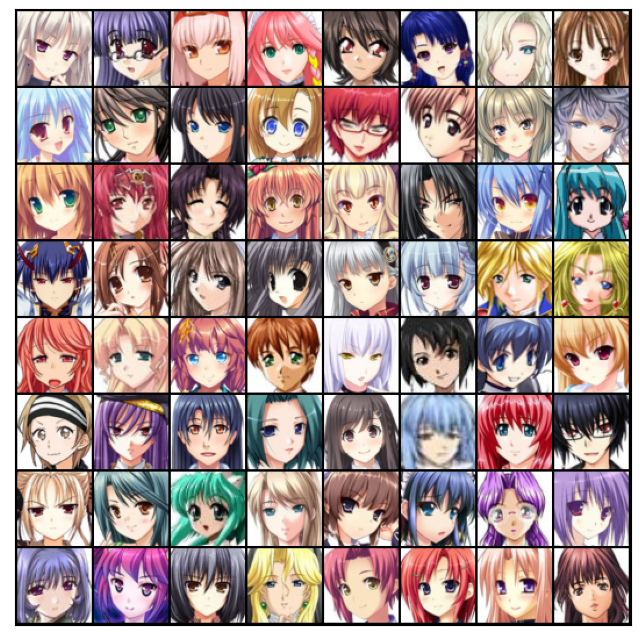

In [8]:
show_batch(train_dl)

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)

In [12]:
import torch.nn as nn

In [13]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [14]:
discriminator = to_device(discriminator, device)

In [15]:
latent_size = 128

In [16]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


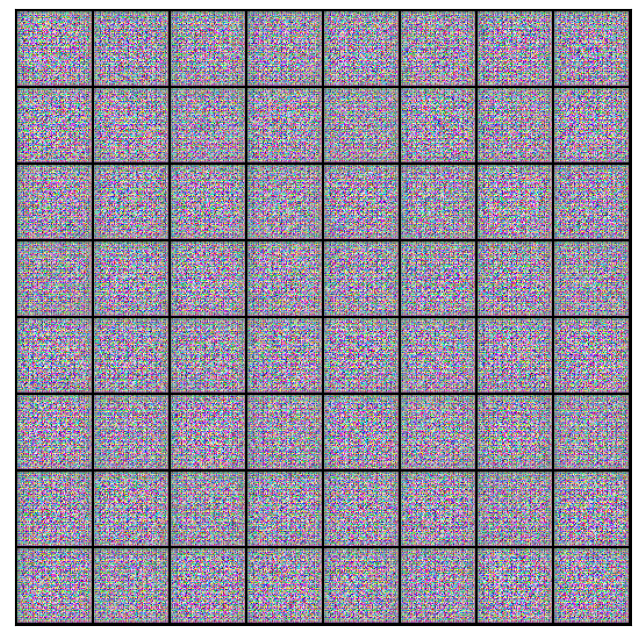

In [17]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [18]:
generator = to_device(generator, device)

In [19]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    # Applying one-sided label smoothing by reducing the real labels slighly less from 1. 
    real_targets = torch.ones(real_images.size(0), 1, device=device) - 0.1
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights only if loss is greater than threshold
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()

    return loss.item(), real_score, fake_score


In [20]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [21]:
from torchvision.utils import save_image

In [22]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [23]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [24]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


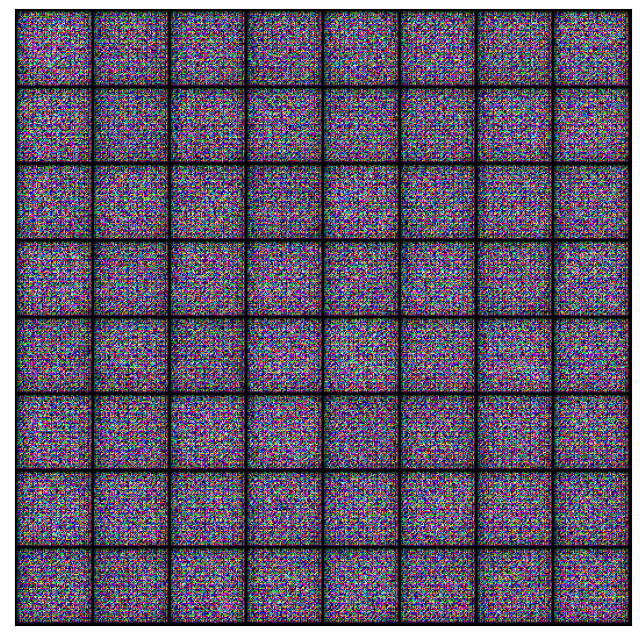

In [25]:
save_samples(0, fixed_latent)

In [26]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [27]:
def fit(epochs, lr, start_idx=1, losses_g=[], losses_d=[], real_scores=[], fake_scores=[]):
    torch.cuda.empty_cache()
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        
        batch_losses_d, batch_losses_g, batch_real_scores, batch_fake_scores= [], [], [], []        
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
           
            # Train generator
            loss_g = train_generator(opt_g)
       
            batch_losses_g.append(loss_g)
            batch_losses_d.append(loss_d)
            batch_real_scores.append(real_score)
            batch_fake_scores.append(fake_score)
        

        # Record losses & scores
        losses_g.extend(batch_losses_g)
        losses_d.extend(batch_losses_d)
        
        real_scores.extend(batch_real_scores)
        fake_scores.extend(batch_fake_scores)

        
        # Calculate epoch scores
        epoch_loss_g = np.mean(losses_g[-len(batch_losses_g):])
        epoch_loss_d = np.mean(losses_d[-len(batch_losses_d):])

        
        epoch_real_score = np.mean(real_scores[-len(batch_real_scores):])
        epoch_fake_score = np.mean(fake_scores[-len(batch_fake_scores):])

        
        # Log losses & scores (last batch)
        print(f"Epoch [{ epoch+1}/{epochs}]")
        print(f'Loss_D: {epoch_loss_d:.3f}, Loss_G: {epoch_loss_g:.3f}')
        print(f'Real_Score: {real_score:.3f}, Fake_Score: {fake_score:.3f}') 
        # Save generated images
        if (epoch+start_idx) % 10 == 0:
            save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [28]:
lr = 0.0002
epochs = 50

In [29]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/50]
Loss_D: 0.835, Loss_G: 4.879
Real_Score: 0.711, Fake_Score: 0.127


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/50]
Loss_D: 0.759, Loss_G: 4.821
Real_Score: 0.837, Fake_Score: 0.090


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/50]
Loss_D: 0.684, Loss_G: 4.916
Real_Score: 0.781, Fake_Score: 0.037


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/50]
Loss_D: 0.613, Loss_G: 5.012
Real_Score: 0.888, Fake_Score: 0.093


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/50]
Loss_D: 0.596, Loss_G: 4.883
Real_Score: 0.928, Fake_Score: 0.134


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/50]
Loss_D: 0.578, Loss_G: 4.896
Real_Score: 0.727, Fake_Score: 0.030


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/50]
Loss_D: 0.608, Loss_G: 4.865
Real_Score: 0.747, Fake_Score: 0.022


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/50]
Loss_D: 0.569, Loss_G: 4.587
Real_Score: 0.796, Fake_Score: 0.068


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/50]
Loss_D: 0.579, Loss_G: 4.394
Real_Score: 0.871, Fake_Score: 0.108


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/50]
Loss_D: 0.550, Loss_G: 4.368
Real_Score: 0.840, Fake_Score: 0.097
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/50]
Loss_D: 0.578, Loss_G: 4.210
Real_Score: 0.936, Fake_Score: 0.051


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/50]
Loss_D: 0.572, Loss_G: 4.082
Real_Score: 0.698, Fake_Score: 0.026


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/50]
Loss_D: 0.585, Loss_G: 3.913
Real_Score: 0.665, Fake_Score: 0.043


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/50]
Loss_D: 0.577, Loss_G: 3.848
Real_Score: 0.756, Fake_Score: 0.024


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/50]
Loss_D: 0.556, Loss_G: 3.903
Real_Score: 0.799, Fake_Score: 0.044


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/50]
Loss_D: 0.564, Loss_G: 3.792
Real_Score: 0.943, Fake_Score: 0.123


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/50]
Loss_D: 0.612, Loss_G: 3.717
Real_Score: 0.752, Fake_Score: 0.057


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/50]
Loss_D: 0.544, Loss_G: 3.729
Real_Score: 0.827, Fake_Score: 0.027


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/50]
Loss_D: 0.547, Loss_G: 3.738
Real_Score: 0.938, Fake_Score: 0.097


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/50]
Loss_D: 0.590, Loss_G: 3.644
Real_Score: 0.790, Fake_Score: 0.070
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/50]
Loss_D: 0.608, Loss_G: 3.670
Real_Score: 0.429, Fake_Score: 0.070


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/50]
Loss_D: 0.531, Loss_G: 3.579
Real_Score: 0.649, Fake_Score: 0.008


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/50]
Loss_D: 0.555, Loss_G: 3.664
Real_Score: 0.812, Fake_Score: 0.053


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/50]
Loss_D: 0.516, Loss_G: 3.748
Real_Score: 0.934, Fake_Score: 0.089


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/50]
Loss_D: 0.534, Loss_G: 3.747
Real_Score: 0.943, Fake_Score: 0.099


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/50]
Loss_D: 0.526, Loss_G: 3.747
Real_Score: 0.665, Fake_Score: 0.013


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [27/50]
Loss_D: 0.617, Loss_G: 3.651
Real_Score: 0.982, Fake_Score: 0.367


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [28/50]
Loss_D: 0.498, Loss_G: 3.755
Real_Score: 0.679, Fake_Score: 0.051


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [29/50]
Loss_D: 0.493, Loss_G: 3.874
Real_Score: 0.783, Fake_Score: 0.021


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [30/50]
Loss_D: 0.541, Loss_G: 3.781
Real_Score: 0.724, Fake_Score: 0.012
Saving generated-images-0030.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [31/50]
Loss_D: 0.586, Loss_G: 3.720
Real_Score: 0.978, Fake_Score: 0.172


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [32/50]
Loss_D: 0.535, Loss_G: 3.788
Real_Score: 0.732, Fake_Score: 0.034


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [33/50]
Loss_D: 0.498, Loss_G: 3.832
Real_Score: 0.824, Fake_Score: 0.024


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [34/50]
Loss_D: 0.491, Loss_G: 3.874
Real_Score: 0.849, Fake_Score: 0.018


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [35/50]
Loss_D: 0.633, Loss_G: 3.627
Real_Score: 0.914, Fake_Score: 0.073


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [36/50]
Loss_D: 0.446, Loss_G: 3.912
Real_Score: 0.811, Fake_Score: 0.022


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [37/50]
Loss_D: 0.567, Loss_G: 3.761
Real_Score: 0.743, Fake_Score: 0.035


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [38/50]
Loss_D: 0.519, Loss_G: 3.812
Real_Score: 0.707, Fake_Score: 0.041


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [39/50]
Loss_D: 0.482, Loss_G: 3.910
Real_Score: 0.922, Fake_Score: 0.023


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [40/50]
Loss_D: 0.511, Loss_G: 3.924
Real_Score: 0.918, Fake_Score: 0.053
Saving generated-images-0040.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [41/50]
Loss_D: 0.492, Loss_G: 3.961
Real_Score: 0.812, Fake_Score: 0.015


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [42/50]
Loss_D: 0.482, Loss_G: 3.999
Real_Score: 0.840, Fake_Score: 0.017


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [43/50]
Loss_D: 0.475, Loss_G: 4.084
Real_Score: 0.865, Fake_Score: 0.031


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [44/50]
Loss_D: 0.571, Loss_G: 3.818
Real_Score: 0.744, Fake_Score: 0.015


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [45/50]
Loss_D: 0.424, Loss_G: 4.141
Real_Score: 0.851, Fake_Score: 0.029


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [46/50]
Loss_D: 0.489, Loss_G: 4.138
Real_Score: 0.852, Fake_Score: 0.017


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [47/50]
Loss_D: 0.512, Loss_G: 4.101
Real_Score: 0.941, Fake_Score: 0.078


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [48/50]
Loss_D: 0.451, Loss_G: 4.127
Real_Score: 0.942, Fake_Score: 0.064


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [49/50]
Loss_D: 0.532, Loss_G: 4.100
Real_Score: 0.767, Fake_Score: 0.021


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [50/50]
Loss_D: 0.473, Loss_G: 4.031
Real_Score: 0.781, Fake_Score: 0.013
Saving generated-images-0050.png


In [43]:
history = fit(50, lr, start_idx=51, losses_g=losses_g, losses_d=losses_d, real_scores=real_scores, fake_scores=fake_scores)
losses_g, losses_d, real_scores, fake_scores = history

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/50]
Loss_D: 0.485, Loss_G: 4.140
Real_Score: 0.932, Fake_Score: 0.031


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/50]
Loss_D: 0.470, Loss_G: 4.149
Real_Score: 0.846, Fake_Score: 0.013


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/50]
Loss_D: 0.528, Loss_G: 4.212
Real_Score: 0.930, Fake_Score: 0.083


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/50]
Loss_D: 0.478, Loss_G: 4.083
Real_Score: 0.869, Fake_Score: 0.049


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/50]
Loss_D: 0.434, Loss_G: 4.287
Real_Score: 0.535, Fake_Score: 0.025


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/50]
Loss_D: 0.458, Loss_G: 4.198
Real_Score: 0.802, Fake_Score: 0.016


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/50]
Loss_D: 0.481, Loss_G: 4.311
Real_Score: 0.753, Fake_Score: 0.053


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/50]
Loss_D: 0.400, Loss_G: 4.361
Real_Score: 0.958, Fake_Score: 0.034


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/50]
Loss_D: 0.527, Loss_G: 4.056
Real_Score: 0.889, Fake_Score: 0.025


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/50]
Loss_D: 0.414, Loss_G: 4.412
Real_Score: 0.866, Fake_Score: 0.014
Saving generated-images-0060.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/50]
Loss_D: 0.490, Loss_G: 4.298
Real_Score: 0.888, Fake_Score: 0.030


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/50]
Loss_D: 0.471, Loss_G: 4.222
Real_Score: 0.834, Fake_Score: 0.021


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/50]
Loss_D: 0.436, Loss_G: 4.382
Real_Score: 0.798, Fake_Score: 0.025


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/50]
Loss_D: 0.473, Loss_G: 4.254
Real_Score: 0.916, Fake_Score: 0.022


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/50]
Loss_D: 0.387, Loss_G: 4.579
Real_Score: 0.870, Fake_Score: 0.011


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/50]
Loss_D: 0.492, Loss_G: 4.180
Real_Score: 0.839, Fake_Score: 0.015


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/50]
Loss_D: 0.538, Loss_G: 4.226
Real_Score: 0.700, Fake_Score: 0.022


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/50]
Loss_D: 0.413, Loss_G: 4.406
Real_Score: 0.264, Fake_Score: 0.003


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/50]
Loss_D: 0.418, Loss_G: 4.423
Real_Score: 0.795, Fake_Score: 0.007


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/50]
Loss_D: 0.418, Loss_G: 4.605
Real_Score: 0.852, Fake_Score: 0.010
Saving generated-images-0070.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/50]
Loss_D: 0.386, Loss_G: 4.696
Real_Score: 0.980, Fake_Score: 0.075


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/50]
Loss_D: 0.494, Loss_G: 4.244
Real_Score: 0.739, Fake_Score: 0.005


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/50]
Loss_D: 0.473, Loss_G: 4.415
Real_Score: 0.953, Fake_Score: 0.020


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/50]
Loss_D: 0.468, Loss_G: 4.548
Real_Score: 0.213, Fake_Score: 0.043


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/50]
Loss_D: 0.443, Loss_G: 4.205
Real_Score: 0.865, Fake_Score: 0.011


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/50]
Loss_D: 0.396, Loss_G: 4.658
Real_Score: 0.947, Fake_Score: 0.028


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [27/50]
Loss_D: 0.421, Loss_G: 4.613
Real_Score: 0.963, Fake_Score: 0.026


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [28/50]
Loss_D: 0.499, Loss_G: 4.436
Real_Score: 0.824, Fake_Score: 0.016


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [29/50]
Loss_D: 0.386, Loss_G: 4.607
Real_Score: 0.850, Fake_Score: 0.006


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [30/50]
Loss_D: 0.521, Loss_G: 4.296
Real_Score: 0.867, Fake_Score: 0.013
Saving generated-images-0080.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [31/50]
Loss_D: 0.433, Loss_G: 4.464
Real_Score: 0.946, Fake_Score: 0.042


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [32/50]
Loss_D: 0.389, Loss_G: 4.648
Real_Score: 0.726, Fake_Score: 0.008


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [33/50]
Loss_D: 0.515, Loss_G: 4.211
Real_Score: 0.905, Fake_Score: 0.020


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [34/50]
Loss_D: 0.382, Loss_G: 4.689
Real_Score: 0.885, Fake_Score: 0.012


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [35/50]
Loss_D: 0.541, Loss_G: 4.290
Real_Score: 0.911, Fake_Score: 0.038


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [36/50]
Loss_D: 0.385, Loss_G: 4.517
Real_Score: 0.870, Fake_Score: 0.010


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [37/50]
Loss_D: 0.396, Loss_G: 4.721
Real_Score: 0.940, Fake_Score: 0.014


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [38/50]
Loss_D: 0.446, Loss_G: 4.472
Real_Score: 0.934, Fake_Score: 0.014


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [39/50]
Loss_D: 0.393, Loss_G: 4.779
Real_Score: 0.902, Fake_Score: 0.016


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [40/50]
Loss_D: 0.536, Loss_G: 4.596
Real_Score: 0.878, Fake_Score: 0.156
Saving generated-images-0090.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [41/50]
Loss_D: 0.394, Loss_G: 4.434
Real_Score: 0.942, Fake_Score: 0.049


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [42/50]
Loss_D: 0.382, Loss_G: 4.801
Real_Score: 0.801, Fake_Score: 0.007


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [43/50]
Loss_D: 0.433, Loss_G: 4.640
Real_Score: 0.956, Fake_Score: 0.019


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [44/50]
Loss_D: 0.432, Loss_G: 4.827
Real_Score: 0.207, Fake_Score: 0.023


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [45/50]
Loss_D: 0.403, Loss_G: 4.499
Real_Score: 0.702, Fake_Score: 0.004


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [46/50]
Loss_D: 0.422, Loss_G: 4.753
Real_Score: 0.833, Fake_Score: 0.009


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [47/50]
Loss_D: 0.389, Loss_G: 4.804
Real_Score: 0.758, Fake_Score: 0.003


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [48/50]
Loss_D: 0.411, Loss_G: 4.870
Real_Score: 0.928, Fake_Score: 0.023


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [49/50]
Loss_D: 0.382, Loss_G: 4.851
Real_Score: 0.920, Fake_Score: 0.022


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [50/50]
Loss_D: 0.421, Loss_G: 4.731
Real_Score: 0.824, Fake_Score: 0.006
Saving generated-images-0100.png


In [31]:
losses_g, losses_d, real_scores, fake_scores = history

In [32]:
import pandas as pd

def plot_results(dist1, dist2, title, window_size1=len(train_dl), window_size2=len(train_dl)):
    x1 = np.arange(0, len(dist1), 1)
    x2 = np.arange(0, len(dist2), 1)
    
    fig, ax = plt.subplots(figsize=(10,6))
    
    # Calculate the rolling means for each distribution
    rolling_mean1 = pd.Series(dist1).rolling(window=window_size1).mean()
    rolling_mean2 = pd.Series(dist2).rolling(window=window_size2).mean()
    
    # Plot the distributions with shading between rolling means
    ax.fill_between(x1, dist1, rolling_mean1, alpha=0.3, label='Real', color='blue')
    ax.fill_between(x2, dist2, rolling_mean2, alpha=0.3, label='Fake', color='orange')

    # Plot the rolling means as lines
    ax.plot(x1, rolling_mean1, label='Moving Mean Real', color='blue')
    ax.plot(x2, rolling_mean2, label='Moving Mean Fake', color='orange')

    # Customize the plot
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title(title)
    ax.legend()

    # Show the plot
    plt.show()    

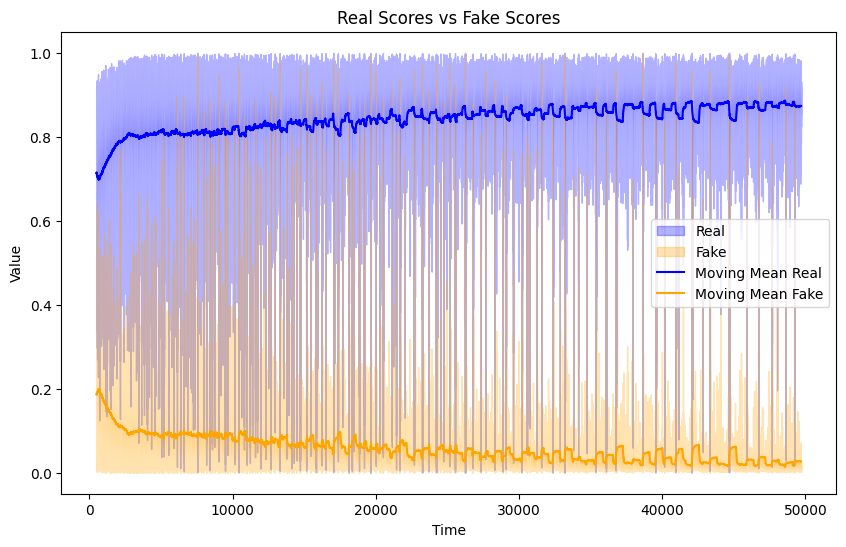

In [45]:
plot_results(real_scores, fake_scores, 'Real Scores vs Fake Scores')

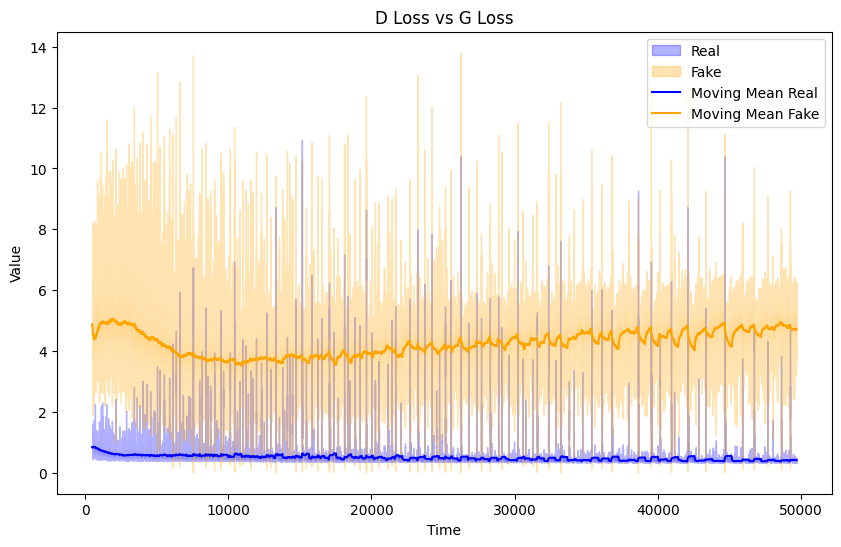

In [46]:
plot_results(losses_d, losses_g, 'D Loss vs G Loss')

In [35]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'Gv3.pth')
torch.save(discriminator.state_dict(), 'Dv3.pth')

In [36]:
import cv2
import os

vid_fname = 'gans_training_v3.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [37]:
from IPython.display import Image

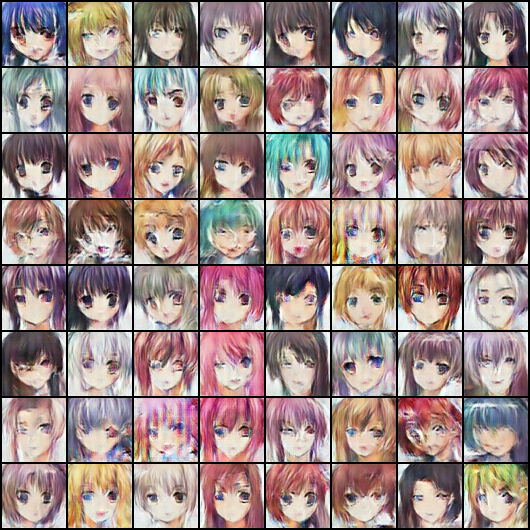

In [38]:
Image('./generated/generated-images-0010.png')

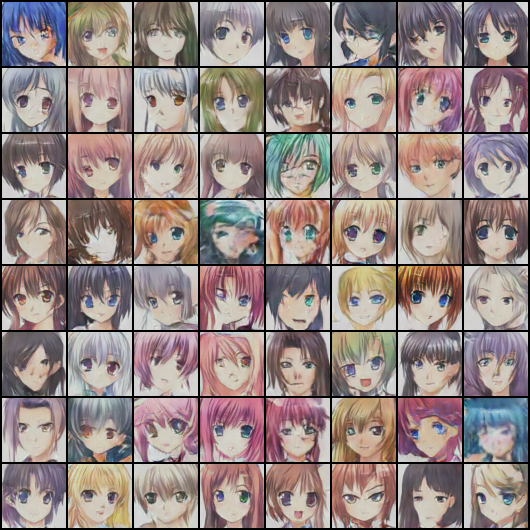

In [39]:
Image('./generated/generated-images-0050.png')

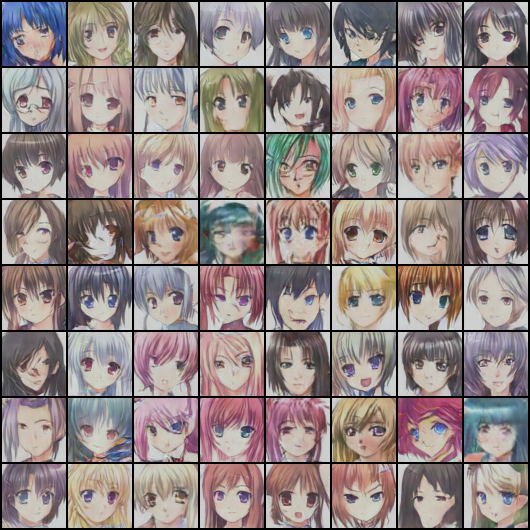

In [44]:
Image('./generated/generated-images-0100.png')

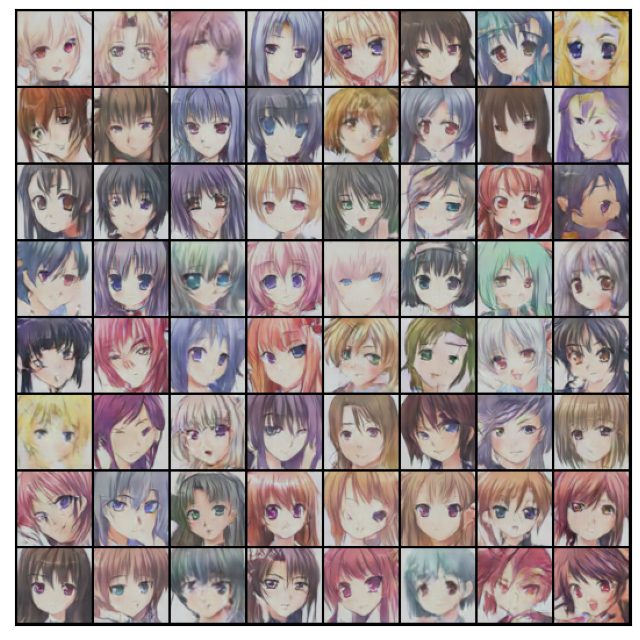

In [54]:
new_latent = torch.randn(64, latent_size, 1, 1, device=device)

fake_images = denorm(generator(new_latent))
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

tensor([[0.0067]], device='cuda:0', grad_fn=<SigmoidBackward0>)


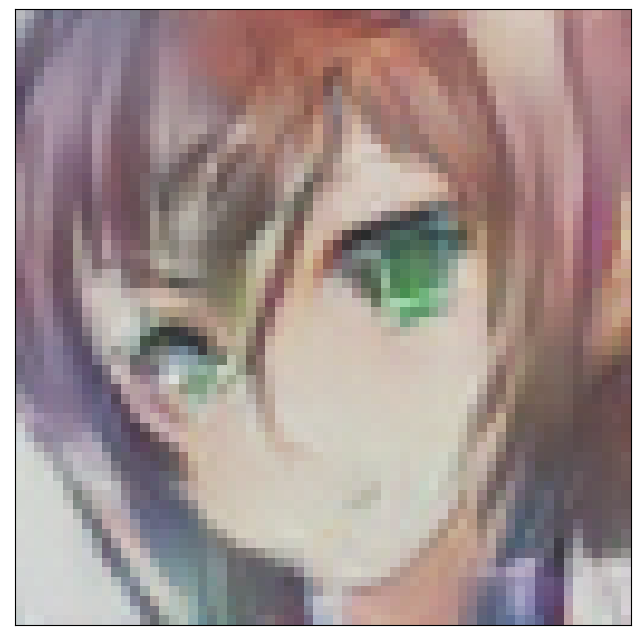

In [42]:
new_latent = torch.randn(1, latent_size, 1, 1, device=device)
fake_images = denorm(generator(new_latent))
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
print(discriminator(generator(new_latent)))

tensor([[4.8634e-05]], device='cuda:0', grad_fn=<SigmoidBackward0>)


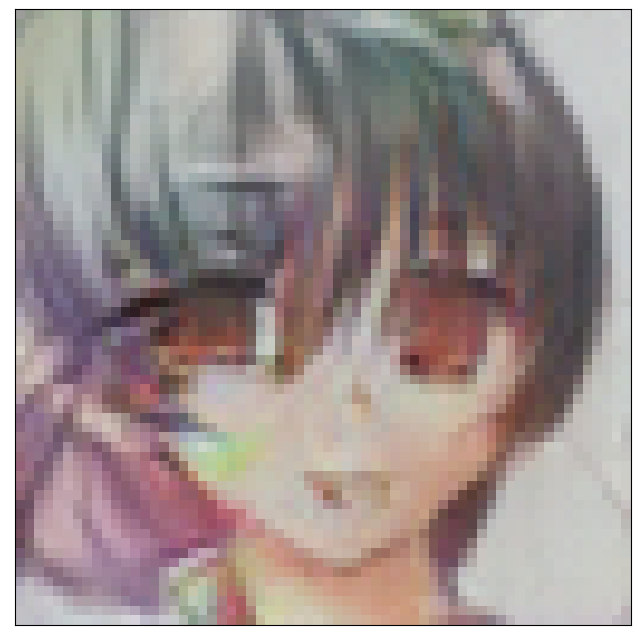

In [55]:
new_latent = torch.randn(1, latent_size, 1, 1, device=device)
fake_images = denorm(generator(new_latent))
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
print(discriminator(generator(new_latent)))